<a href="https://colab.research.google.com/github/icarogga/Object-Detection/blob/main/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import torchvision
import torch
import torch.nn as nn
import torchvision.transforms as T
import os
import xml.etree.ElementTree as ET
from PIL import Image,ImageDraw
from IPython.display import display
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/datasets/object_detection/')
from mapeval import voc_eval

In [ ]:
img = Image.open('imagens/photo_2021-07-03_21-26-58.jpg')

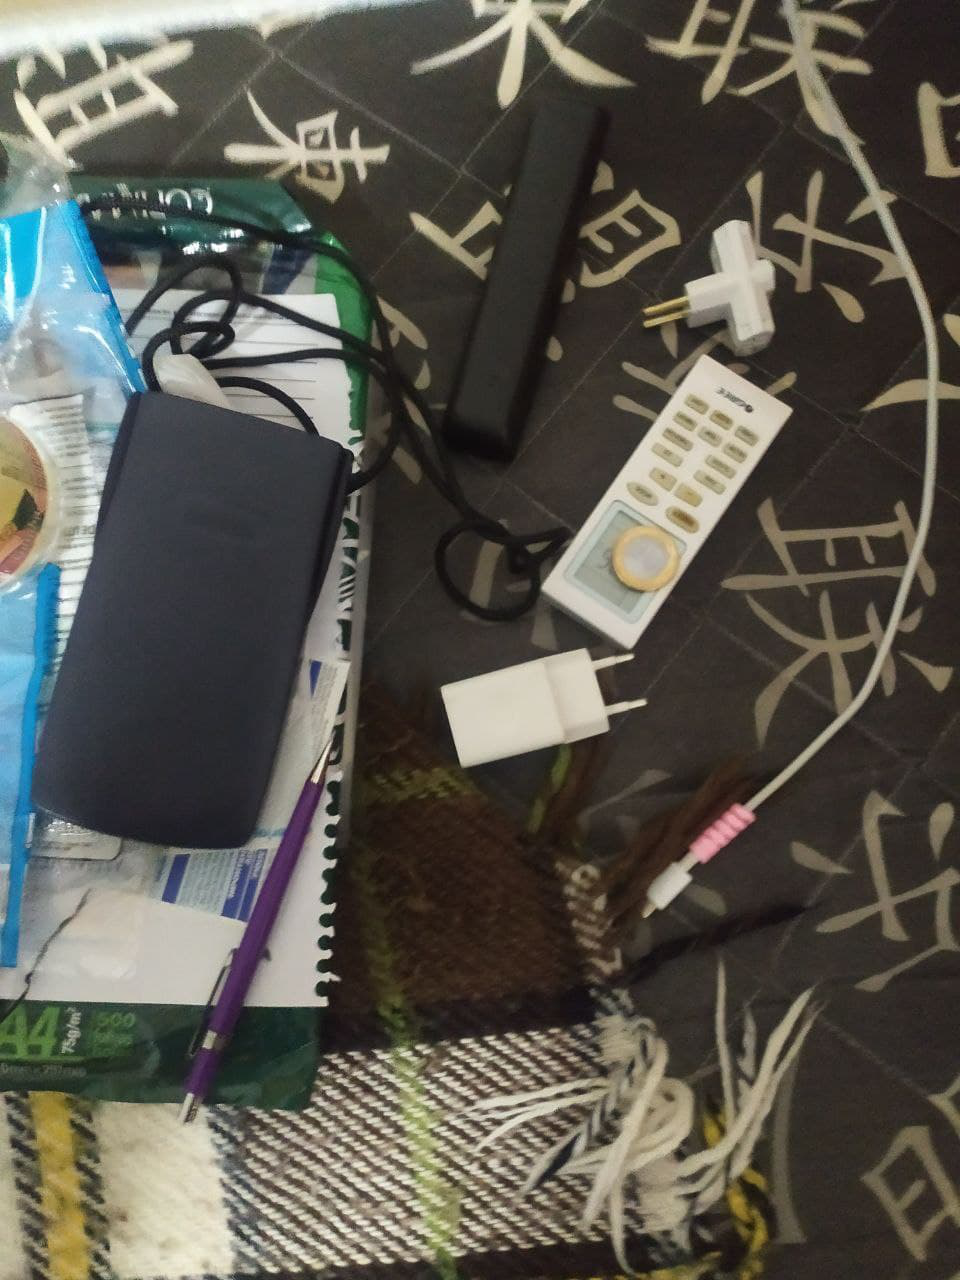

In [ ]:
img

In [ ]:
# dados rotulados de https://www.makesense.ai/
h_files = {}
with open('labels.csv') as csv_file:
    for line in csv_file:
        v = line.split(',')
        class_att = v[0]
        x1,y1,x2,y2 = [int(x) for x in v[1:5]]
        img_file = v[5]
        if img_file not in h_files.keys():
            h_files[img_file] = {'boxes':[],'labels':[]}
        h_files[img_file]['boxes'].append((x1,y1,x2,y2)) 
        h_files[img_file]['labels'].append(class_att)

for img_file in h_files.keys():
    print(img_file)
    print(h_files[img_file]['boxes'])
    print(h_files[img_file]['labels'])



photo_2021-07-03_21-37-40.jpg
[(481, 237, 137, 112), (751, 372, 168, 209), (662, 700, 94, 389), (145, 626, 56, 53), (265, 344, 115, 104), (369, 461, 186, 316), (117, 774, 224, 280)]
['carregador', 'controle ar', 'controle tv', 'moeda', 'T', 'calculadora', 'lapiseira']
photo_2021-07-03_21-37-41.jpg
[(79, 211, 280, 275), (502, 239, 92, 94), (657, 254, 257, 257), (553, 578, 349, 506), (8, 514, 440, 318), (125, 522, 481, 573), (372, 61, 573, 547)]
['carregador', 'moeda', 'T', 'controle ar', 'lapiseira', 'controle tv', 'calculadora']
photo_2021-07-03_21-37-42.jpg
[(283, 178, 557, 478), (217, 611, 104, 97), (36, 295, 272, 226), (598, 664, 326, 511), (0, 517, 331, 547), (351, 532, 226, 239), (507, 651, 206, 504)]
['calculadora', 'moeda', 'carregador', 'controle ar', 'controle tv', 'T', 'lapiseira']
photo_2021-07-03_21-37-43.jpg
[(494, 239, 440, 288), (530, 629, 99, 107), (397, 769, 219, 336), (117, 453, 372, 463)]
['lapiseira', 'moeda', 'carregador', 'controle ar']
photo_2021-07-03_21-37-44.j

In [ ]:
class MyDataset():
    def __init__(self,transforms = None):
        self.data = []
        self.transforms = transforms
        self.target_names = ['blank']
        self.htarget_names = {'blank':0,'controle ar':1,'controle tv':2, 'calculadora':3, 'moeda':4, 'lapiseira':5, 'T':6, 'carregador':7}
        self.read_csv()

    def get_label_id(self,name):
        if name not in self.htarget_names:
            self.htarget_names[name] = len(self.target_names)
            self.target_names.append(name)
        return self.htarget_names[name]
    
    def read_csv(self):
        h_files = {}
        with open('labels.csv') as csv_file:
            for line in csv_file:
                v = line.split(',')
                class_att = v[0]
                x1,y1,width,height = [int(x) for x in v[1:5]]
                x2 = x1 + width
                y2 = y1 + height
                img_file = v[5]
                if img_file not in h_files.keys():
                    h_files[img_file] = {'boxes':[],'labels':[]}
                h_files[img_file]['boxes'].append((x1,y1,x2,y2)) 
                h_files[img_file]['labels'].append(self.get_label_id(class_att))

        for img_file in h_files.keys():
            h = {}
            h['file_img'] = 'imagens/'+img_file
            h['labels'] = h_files[img_file]['labels']
            h['boxes']  = h_files[img_file]['boxes']
            self.data.append(h)


    def read_json(self):
        with open('labels.json') as json_file:
            data = json.load(json_file)
            for h in data:
                if 'objects' in h['Label']:
                    file_url = h['Labeled Data']
                    file_name = 'imagens'+os.sep+h['External ID']
                    objects = h['Label']['objects']
                    boxes = []
                    labels = []
                    for obj in objects:
                        labels.append(self.get_label_id(obj['value']))
                        x1 = int(obj['bbox']['left'])
                        y1 = int(obj['bbox']['top'])
                        x2 = x1 + int(obj['bbox']['width'])
                        y2 = y1 + int(obj['bbox']['height'])
                        bbox  = [x1,y1,x2,y2]
                        boxes.append(bbox)
                    h = {}
                    h['file_img'] = file_name
                    h['labels'] = labels
                    h['boxes']  = boxes
                    self.data.append(h)
    def __getitem__(self,i):
        img   = Image.open(self.data[i]['file_img']).convert("RGB")
        boxes = torch.tensor(self.data[i]['boxes'])
        if self.transforms != None:
            img,boxes = self.transforms(img,boxes)
        r = dict()
        r['boxes']   = boxes
        r['labels']  = torch.tensor(self.data[i]['labels'])
        return img,r
    def __len__(self):
        return len(self.data)              


In [ ]:
def resize(img,boxes,size):
    w, h = img.size
    ow, oh = size
    sw = float(ow) / w
    sh = float(oh) / h
    img = img.resize((ow,oh), Image.BILINEAR)
    boxes = boxes * torch.tensor([sw,sh,sw,sh])
    return img, boxes

In [ ]:
size = (300,300)
def transform_data(img,boxes):
    img,boxes = resize(img,boxes,size)
    img = T.Compose([
          T.ToTensor(), 
          T.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))          
    ])(img)
    return img,boxes

In [ ]:
data = MyDataset(transforms=transform_data)

# Dividindo o conjunto em treino, validação e teste

In [ ]:
n = len(data)
n_treino = int(0.7*n)
n_valid = int((n - n_treino) * 0.5)
n_teste  = int((n - n_treino) * 0.5)

In [ ]:
n,n_treino,n_teste, n_valid

(200, 140, 30, 30)

In [ ]:
ds_treino,ds_teste,ds_valid = torch.utils.data.random_split(data,[n_treino,n_teste,n_valid])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))
dl_treino = torch.utils.data.DataLoader(ds_treino,batch_size = 10,collate_fn=collate_fn)
dl_teste  = torch.utils.data.DataLoader(ds_teste,batch_size = 10,collate_fn=collate_fn)
dl_valid  = torch.utils.data.DataLoader(ds_valid,batch_size = 10,collate_fn=collate_fn)

In [ ]:
imgs,targets = next(iter(dl_treino))

In [ ]:
len(imgs)

10

In [ ]:
len(dl_treino)

14

In [ ]:
nview = Image.open(data.data[0]['file_img'])

In [ ]:
data.data[0]['boxes']

[(481, 237, 618, 349),
 (751, 372, 919, 581),
 (662, 700, 756, 1089),
 (145, 626, 201, 679),
 (265, 344, 380, 448),
 (369, 461, 555, 777),
 (117, 774, 341, 1054)]

In [ ]:
def draw_boxes(img,boxes,labels):
    imdraw = ImageDraw.Draw(img)
    for (box,label) in zip(boxes,labels):
        box = list(box)
        imdraw.rectangle(box,outline='red')
        text = "%d"%(label)
        imdraw.text((box[0],box[1]),text,fill='red')
    display(img)

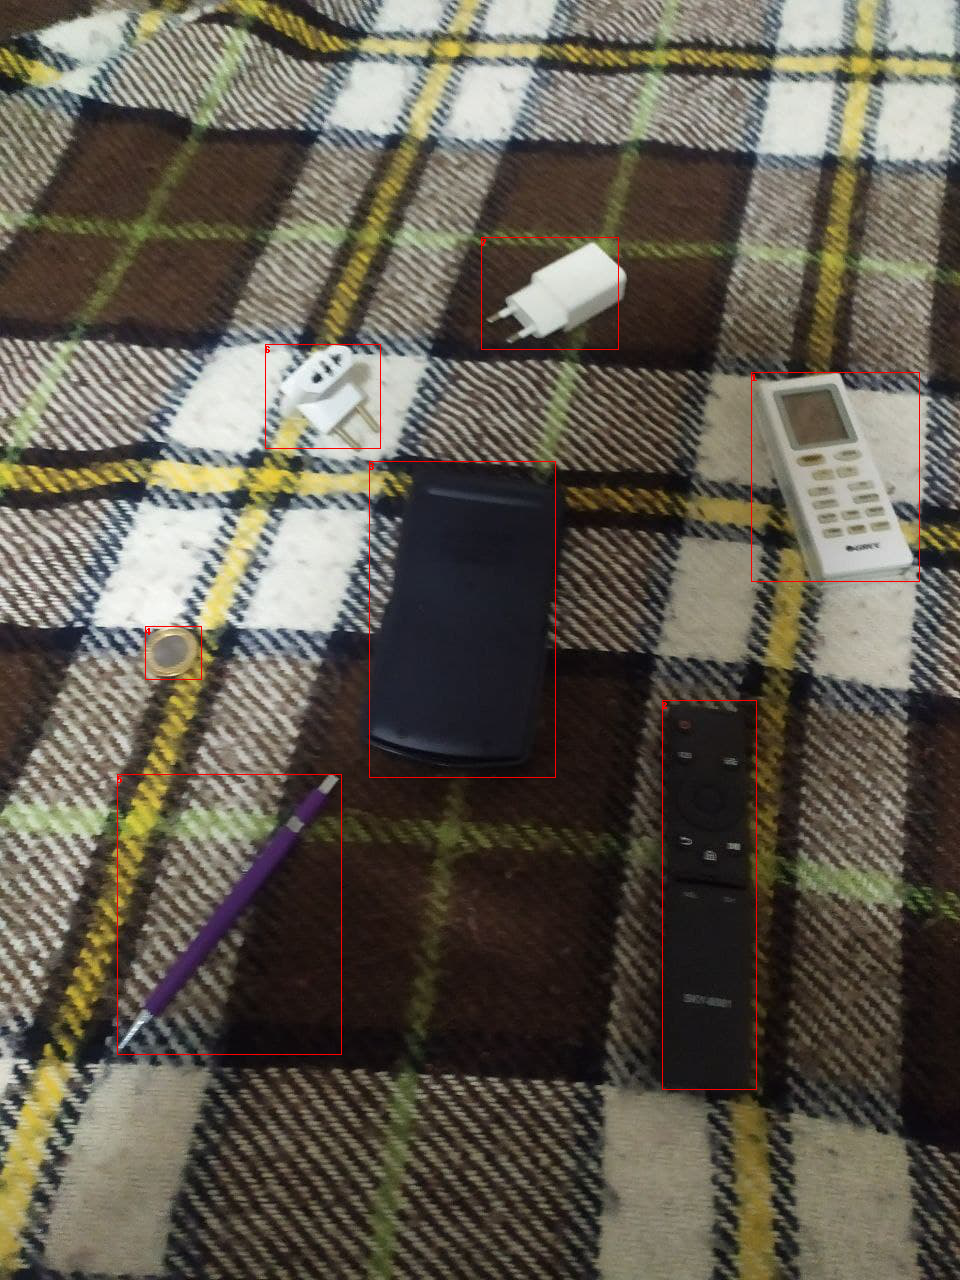

In [ ]:
draw_boxes(nview,data.data[0]['boxes'],data.data[0]['labels'])

In [ ]:
nview = T.ToPILImage()(imgs[0]*torch.Tensor([0.229,0.224,0.225]).view(3,1,1)+torch.Tensor([0.485,0.456,0.406]).view(3,1,1))

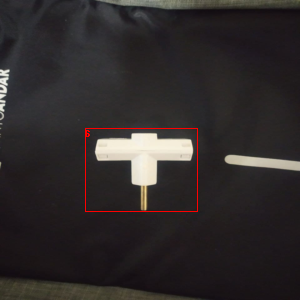

In [ ]:
draw_boxes(nview,targets[0]['boxes'],targets[0]['labels'])

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
# Fine tunning
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features,8)

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
def train(epoch):
    model.train()
    bloss=[]
    for images,targets in dl_treino:
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        loss_dict = model(images,targets)
        losses = sum(loss for loss in loss_dict.values())
        
        opt.zero_grad()
        losses.backward()
        opt.step()
        #print(loss_dict)
        #wlog = {}
        for loss in loss_dict.keys():
            print("%.10s %4.3f"%(loss,loss_dict[loss].item()))
        print("Total Loss %4.3f\n"%(losses))
        bloss.append(losses.item())
    
    print("\nEPOCH %d LR %5.5f\n"%(epoch,opt.param_groups[0]['lr']))

In [ ]:
def evaluate(epoch):
    model.eval()
    pred_boxes = []
    pred_labels = []
    pred_scores = []
    gt_boxes = []
    gt_labels = []
    lmap = []
    lap  = []
    with torch.no_grad():
        for images,targets in dl_valid:
            images = list(image.to(device) for image in images)
            pred   = model(images)
            for i in range(len(targets)):
                gt_boxes.append(targets[i]['boxes'])
                gt_labels.append(targets[i]['labels'])
                pred_boxes.append(pred[i]['boxes'].cpu())
                pred_labels.append(pred[i]['labels'].cpu())
                pred_scores.append(pred[i]['scores'].cpu())
                r = voc_eval(pred_boxes, pred_labels, pred_scores,
                gt_boxes, gt_labels)
                # print(r)
                lmap.append(r['map'])
                #lap.append(r['ap'])
    print(np.mean(lmap))
    #print(np.mean(lap,axis=0))
    return np.mean(lmap)

In [ ]:
best_map = 0.0
maps = []

# Treinamento até 50 epochs

Vi utilizando a metodologia do cotovelo que não é necessário treinar até o epoch 50, pois a partir do 24 o treino já tem uma precisão estável, então posso parar entre o epoch 24 e 28, escolhi treinar até o 26 desde então

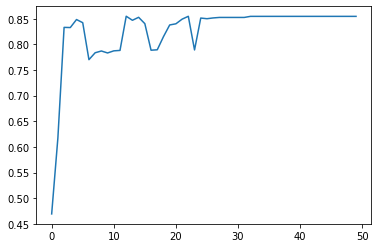

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(maps)
img = Image.open('train-until-epoch-50.png')
img

# Código para encontrar os melhores parâmetros utilizando o conjunto de validação


In [ ]:
'''
lrs = [0.01, 0.0075, 0.005]
momentums = [0.9, 0.95, 0.8]
weight_decay = 0.0005

best_params = {}
for lr in lrs:
  for momentum in momentums:
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)

    # 0.78 for dl_valid
    for epoch in range(10):
        train(epoch)
        map = evaluate(epoch)
        maps.append(map)
        lr_scheduler.step(1.0-map)
        if map > best_map:
            best_map = map
            torch.save(model,'best_map_labelbox.pth')
            print('saving model')
    print("Best map: " + str(best_map))
    best_params[str(lr)+"_"+str(momentum)] = best_map
    best_map = 0.0
'''

'\nlrs = [0.01, 0.0075, 0.005]\nmomentums = [0.9, 0.95, 0.8]\nweight_decay = 0.0005\n\nbest_params = {}\nfor lr in lrs:\n  for momentum in momentums:\n    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)\n    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)\n\n    # 0.78 for dl_valid\n    for epoch in range(10):\n        train(epoch)\n        map = evaluate(epoch)\n        maps.append(map)\n        lr_scheduler.step(1.0-map)\n        if map > best_map:\n            best_map = map\n            torch.save(model,\'best_map_labelbox.pth\')\n            print(\'saving model\')\n    print("Best map: " + str(best_map))\n    best_params[str(lr)+"_"+str(momentum)] = best_map\n    best_map = 0.0\n'

# Precisão com o conjunto de validação
Utilizando o conjunto de validação eu consegui com 26 epochs uma precisão de 94,79%

In [ ]:
lr = 0.01
momentum = 0.8
weight_decay = 0.0005

opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)

# 0.78 for dl_valid
for epoch in range(26):
    train(epoch)
    map = evaluate(epoch)
    maps.append(map)
    lr_scheduler.step(1.0-map)
    if map > best_map:
      best_map = map
      torch.save(model,'best_map_labelbox.pth')
      print('saving model')
print("Best map: " + str(best_map))


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss_class 0.387
loss_box_r 0.078
loss_objec 0.155
loss_rpn_b 0.039
Total Loss 0.660

loss_class 0.521
loss_box_r 0.207
loss_objec 0.033
loss_rpn_b 0.015
Total Loss 0.775

loss_class 0.436
loss_box_r 0.158
loss_objec 0.033
loss_rpn_b 0.009
Total Loss 0.637

loss_class 0.557
loss_box_r 0.213
loss_objec 0.154
loss_rpn_b 0.017
Total Loss 0.941

loss_class 0.460
loss_box_r 0.187
loss_objec 0.046
loss_rpn_b 0.009
Total Loss 0.703

loss_class 0.612
loss_box_r 0.277
loss_objec 0.057
loss_rpn_b 0.015
Total Loss 0.960

loss_class 0.426
loss_box_r 0.253
loss_objec 0.080
loss_rpn_b 0.016
Total Loss 0.775

loss_class 0.474
loss_box_r 0.266
loss_objec 0.064
loss_rpn_b 0.017
Total Loss 0.822

loss_class 0.427
loss_box_r 0.252
loss_objec 0.026
loss_rpn_b 0.013
Total Loss 0.718

loss_class 0.404
loss_box_r 0.233
loss_objec 0.028
loss_rpn_b 0.017
Total Loss 0.682

loss_class 0.266
loss_box_r 0.122
loss_objec 0.019
loss_rpn_b 0.012
Total Loss 0.419

loss_class 0.379
loss_box_r 0.266
loss_objec 0.038
los

In [ ]:
nview = T.ToPILImage()(imgs[-1]*torch.Tensor([0.229,0.224,0.225]).view(3,1,1)+torch.Tensor([0.485,0.456,0.406]).view(3,1,1))

In [ ]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
pred = model(imgs[-1].view([1,3,300,300]).to(device))

In [ ]:
pred

[{'boxes': tensor([[  0.0000,  32.9947, 126.2389, 183.0387],
          [208.2075, 133.3138, 297.3130, 190.0623],
          [219.2059,  97.5504, 280.3293, 139.2019],
          [ 79.9856, 134.9365, 113.6236, 159.6257]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([3, 7, 6, 4], device='cuda:0'),
  'scores': tensor([0.9994, 0.9954, 0.9923, 0.9923], device='cuda:0',
         grad_fn=<IndexBackward>)}]

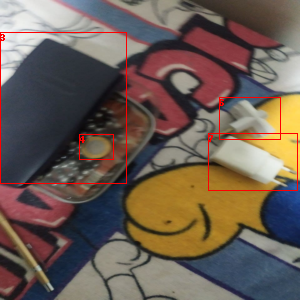

In [ ]:
draw_boxes(nview,pred[0]['boxes'],pred[0]['labels'])

In [ ]:
htarget_names = {'blank':0,'controle ar':1,'controle tv':2, 'calculadora':3, 'moeda':4, 'lapiseira':5, 'T':6, 'carregador':7}

In [ ]:
dict_pred = {index: name for (index, name) in enumerate(htarget_names)}

In [ ]:
dict_pred

{0: 'blank',
 1: 'controle ar',
 2: 'controle tv',
 3: 'calculadora',
 4: 'moeda',
 5: 'lapiseira',
 6: 'T',
 7: 'carregador'}

In [ ]:
def validation_data(data):
    pred_boxes = []
    pred_labels = []
    pred_scores = []
    gt_boxes = []
    gt_labels = []
    lmap = []
    lap  = []
    with torch.no_grad():
        for images,targets in data:
            images = list(image.to(device) for image in images)
            pred   = model(images)
            for i in range(len(targets)):
                gt_boxes.append(targets[i]['boxes'])
                gt_labels.append(targets[i]['labels'])
                pred_boxes.append(pred[i]['boxes'].cpu())
                pred_labels.append(pred[i]['labels'].cpu())
                pred_scores.append(pred[i]['scores'].cpu())
                r = voc_eval(pred_boxes, pred_labels, pred_scores,
                gt_boxes, gt_labels)
                # print(r)
                lmap.append(r['map'])
                #lap.append(r['ap'])
    print(np.mean(lmap))
    #print(np.mean(lap,axis=0))
    return np.mean(lmap)

# Precisão com o conjunto de treino
Utilizando o conjunto de treino eu consegui com 26 epochs uma precisão de 100%

In [ ]:
# 0.85 for dl_treino
validation_data(dl_treino)

1.0000000000000002


1.0000000000000002

# Precisão com o conjunto de teste
Utilizando o conjunto de teste eu consegui com 26 epochs uma precisão de 97,89%


In [ ]:
# 0.75 for dl_teste
validation_data(dl_teste)

0.9789536922217575


0.9789536922217575

In [ ]:
preds_test = []
images_test_new = []
targets_test_new = []
for images,targets in dl_teste:
  for index, image in enumerate(images):
    images_test_new.append(image)
    targets_test_new.append(targets[index])
    preds_test.append(model(image.view([1,3,300,300]).to(device)))

# Analisando as predições
Usei como threshold a confiança de 70% na predição do objeto para avaliar a precisão do meu algoritmo acertando os objetos 

In [ ]:
'''
new_preds_test_scores = []
new_preds_test_label = []

for pred in preds_test[0]:
  for index, score in enumerate(pred['scores']):
    if score.item() > 0.9:
      new_preds_test_scores.append(score.item())
      new_preds_test_label.append(pred['labels'][index].item())
'''

"\nnew_preds_test_scores = []\nnew_preds_test_label = []\n\nfor pred in preds_test[0]:\n  for index, score in enumerate(pred['scores']):\n    if score.item() > 0.9:\n      new_preds_test_scores.append(score.item())\n      new_preds_test_label.append(pred['labels'][index].item())\n"

In [ ]:
new_preds_test_scores = []
new_preds_test_label = []

for pred_array in preds_test:
  pred = pred_array[0]
  pred_scores = []
  pred_label = []
  for index, score in enumerate(pred['scores']):
    if score.item() > 0.7:
      pred_scores.append(score.item())
      pred_label.append(pred['labels'][index].item())
  new_preds_test_scores.append(pred_scores)
  new_preds_test_label.append(pred_label)

In [ ]:
images_accuracy = {}
images_total_correct_labels = {}
images_expected_labels = {}
for test_image in range(len(new_preds_test_scores)):
  predicted_labels = []
  expected_labels = []
  correct_label = 0
  for index, predicted in enumerate(new_preds_test_scores[test_image]):
    predicted_labels.append(dict_pred[new_preds_test_label[test_image][index]])
  predicted_labels = set(predicted_labels)

  for i in targets_test_new[test_image]['labels']:
    expected_labels.append(dict_pred[i.max().cpu().item()])
  images_expected_labels[test_image] = len(expected_labels)

  for element in predicted_labels:
    if element in expected_labels:
      correct_label += 1

  accuracy_image = correct_label/len(expected_labels) * 100
  images_accuracy[test_image] = accuracy_image
  images_total_correct_labels[test_image] = correct_label

In [ ]:
images_accuracy

{0: 100.0,
 1: 100.0,
 2: 100.0,
 3: 85.71428571428571,
 4: 100.0,
 5: 100.0,
 6: 100.0,
 7: 0.0,
 8: 75.0,
 9: 100.0,
 10: 100.0,
 11: 100.0,
 12: 50.0,
 13: 100.0,
 14: 100.0,
 15: 100.0,
 16: 100.0,
 17: 33.33333333333333,
 18: 100.0,
 19: 100.0,
 20: 100.0,
 21: 100.0,
 22: 100.0,
 23: 100.0,
 24: 100.0,
 25: 100.0,
 26: 83.33333333333334,
 27: 100.0,
 28: 100.0,
 29: 0.0}

In [ ]:
ordered_accuracy = dict(sorted(images_accuracy.items(), key=lambda item: item[1]))
print("Piores imagens")
print(list(ordered_accuracy)[:10])

for image in list(ordered_accuracy)[:10]:
  print("Imagem index: " + str(image) + " com acerto de " + str(images_accuracy[image]) + "% acertando " + str(images_total_correct_labels[image]) + " objetos de um total de " + str(images_expected_labels[image]) + " objetos na imagem")

Piores imagens
[7, 29, 17, 12, 8, 26, 3, 0, 1, 2]
Imagem index: 7 com acerto de 0.0% acertando 0 objetos de um total de 1 objetos na imagem
Imagem index: 29 com acerto de 0.0% acertando 0 objetos de um total de 1 objetos na imagem
Imagem index: 17 com acerto de 33.33333333333333% acertando 1 objetos de um total de 3 objetos na imagem
Imagem index: 12 com acerto de 50.0% acertando 1 objetos de um total de 2 objetos na imagem
Imagem index: 8 com acerto de 75.0% acertando 3 objetos de um total de 4 objetos na imagem
Imagem index: 26 com acerto de 83.33333333333334% acertando 5 objetos de um total de 6 objetos na imagem
Imagem index: 3 com acerto de 85.71428571428571% acertando 6 objetos de um total de 7 objetos na imagem
Imagem index: 0 com acerto de 100.0% acertando 6 objetos de um total de 6 objetos na imagem
Imagem index: 1 com acerto de 100.0% acertando 1 objetos de um total de 1 objetos na imagem
Imagem index: 2 com acerto de 100.0% acertando 7 objetos de um total de 7 objetos na ima

In [ ]:
print("Melhores imagens")
print(list(ordered_accuracy)[-10:])

for image in list(ordered_accuracy)[-10:]:
    print("Imagem index: " + str(image) + " com acerto de " + str(images_accuracy[image]) + "% acertando " + str(images_total_correct_labels[image]) + " objetos de um total de " + str(images_expected_labels[image]) + " objetos na imagem")

Melhores imagens
[18, 19, 20, 21, 22, 23, 24, 25, 27, 28]
Imagem index: 18 com acerto de 100.0% acertando 1 objetos de um total de 1 objetos na imagem
Imagem index: 19 com acerto de 100.0% acertando 7 objetos de um total de 7 objetos na imagem
Imagem index: 20 com acerto de 100.0% acertando 1 objetos de um total de 1 objetos na imagem
Imagem index: 21 com acerto de 100.0% acertando 1 objetos de um total de 1 objetos na imagem
Imagem index: 22 com acerto de 100.0% acertando 3 objetos de um total de 3 objetos na imagem
Imagem index: 23 com acerto de 100.0% acertando 1 objetos de um total de 1 objetos na imagem
Imagem index: 24 com acerto de 100.0% acertando 5 objetos de um total de 5 objetos na imagem
Imagem index: 25 com acerto de 100.0% acertando 7 objetos de um total de 7 objetos na imagem
Imagem index: 27 com acerto de 100.0% acertando 7 objetos de um total de 7 objetos na imagem
Imagem index: 28 com acerto de 100.0% acertando 1 objetos de um total de 1 objetos na imagem


# 10 Melhores imagens usando threshold de confiança de 70%

Imagem: 18
Predicted T com certeza de: 0.8485856652259827
Imagem index: 18 com acerto de 100.0% acertando 1 objetos de um total de 1 objetos na imagem


Respostas corretas: 
T


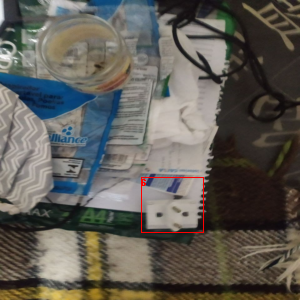




#####################################################################
Imagem: 19
Predicted controle ar com certeza de: 0.9975467324256897
Predicted controle tv com certeza de: 0.9959794282913208
Predicted moeda com certeza de: 0.9845987558364868
Predicted calculadora com certeza de: 0.9721818566322327
Predicted carregador com certeza de: 0.9613586664199829
Predicted T com certeza de: 0.9093097448348999
Predicted lapiseira com certeza de: 0.8541204929351807
Imagem index: 19 com acerto de 100.0% acertando 7 objetos de um total de 7 objetos na imagem


Respostas corretas: 
carregador
moeda
T
controle ar
controle tv
lapiseira
calculadora


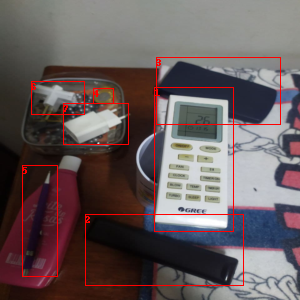




#####################################################################
Imagem: 20
Predicted moeda com certeza de: 0.9958896040916443
Imagem index: 20 com acerto de 100.0% acertando 1 objetos de um total de 1 objetos na imagem


Respostas corretas: 
moeda


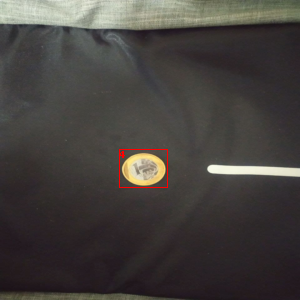




#####################################################################
Imagem: 21
Predicted calculadora com certeza de: 0.9844451546669006
Imagem index: 21 com acerto de 100.0% acertando 1 objetos de um total de 1 objetos na imagem


Respostas corretas: 
calculadora


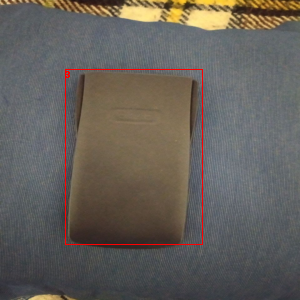




#####################################################################
Imagem: 22
Predicted moeda com certeza de: 0.9972724318504333
Predicted T com certeza de: 0.9877756834030151
Predicted lapiseira com certeza de: 0.986268162727356
Imagem index: 22 com acerto de 100.0% acertando 3 objetos de um total de 3 objetos na imagem


Respostas corretas: 
T
moeda
lapiseira


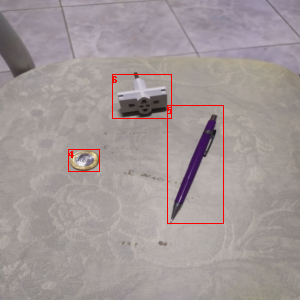




#####################################################################
Imagem: 23
Predicted controle ar com certeza de: 0.9990010857582092
Imagem index: 23 com acerto de 100.0% acertando 1 objetos de um total de 1 objetos na imagem


Respostas corretas: 
controle ar


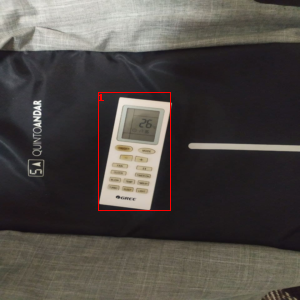




#####################################################################
Imagem: 24
Predicted controle ar com certeza de: 0.9964447617530823
Predicted moeda com certeza de: 0.9947471022605896
Predicted T com certeza de: 0.9939196109771729
Predicted carregador com certeza de: 0.9867158532142639
Predicted lapiseira com certeza de: 0.9644120931625366
Imagem index: 24 com acerto de 100.0% acertando 5 objetos de um total de 5 objetos na imagem


Respostas corretas: 
lapiseira
controle ar
moeda
T
carregador


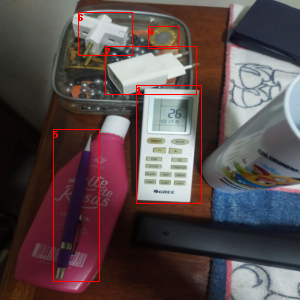




#####################################################################
Imagem: 25
Predicted calculadora com certeza de: 0.9987518787384033
Predicted controle ar com certeza de: 0.9983476400375366
Predicted moeda com certeza de: 0.996997594833374
Predicted controle tv com certeza de: 0.996587872505188
Predicted T com certeza de: 0.9940260648727417
Predicted lapiseira com certeza de: 0.9932721257209778
Predicted carregador com certeza de: 0.9830868244171143
Imagem index: 25 com acerto de 100.0% acertando 7 objetos de um total de 7 objetos na imagem


Respostas corretas: 
controle ar
lapiseira
carregador
controle tv
T
moeda
calculadora


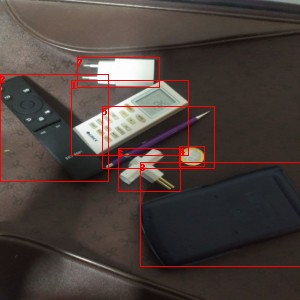




#####################################################################
Imagem: 27
Predicted calculadora com certeza de: 0.9987518787384033
Predicted controle ar com certeza de: 0.9983476400375366
Predicted moeda com certeza de: 0.996997594833374
Predicted controle tv com certeza de: 0.996587872505188
Predicted T com certeza de: 0.9940260648727417
Predicted lapiseira com certeza de: 0.9932721257209778
Predicted carregador com certeza de: 0.9830868244171143
Imagem index: 27 com acerto de 100.0% acertando 7 objetos de um total de 7 objetos na imagem


Respostas corretas: 
calculadora
moeda
controle tv
carregador
controle ar
T
lapiseira


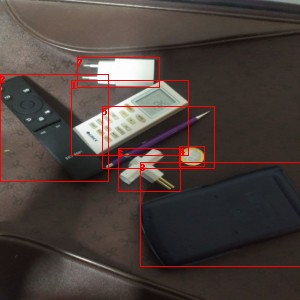




#####################################################################
Imagem: 28
Predicted controle tv com certeza de: 0.9938207268714905
Imagem index: 28 com acerto de 100.0% acertando 1 objetos de um total de 1 objetos na imagem


Respostas corretas: 
controle tv


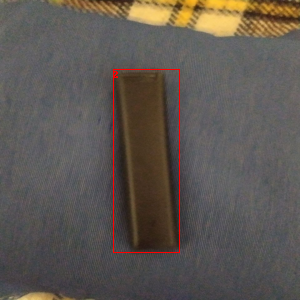




#####################################################################


In [ ]:
for test_image in list(ordered_accuracy)[-10:]:
  print("Imagem: " + str(test_image))
  image_scores = set(new_preds_test_label[test_image])
  for index, predicted in enumerate(image_scores):
    print("Predicted " + str(dict_pred[new_preds_test_label[test_image][index]]) + " com certeza de: " +  str(new_preds_test_scores[test_image][index]))
  print("Imagem index: " + str(test_image) + " com acerto de " + str(images_accuracy[test_image]) + "% acertando " + str(images_total_correct_labels[test_image]) + " objetos de um total de " + str(images_expected_labels[test_image]) + " objetos na imagem")
  print("\n")

  print("Respostas corretas: ")
  for i in targets_test_new[test_image]['labels']:
    print(dict_pred[i.max().cpu().item()])

  nview = T.ToPILImage()(images_test_new[test_image]*torch.Tensor([0.229,0.224,0.225]).view(3,1,1)+torch.Tensor([0.485,0.456,0.406]).view(3,1,1))
  draw_boxes(nview,preds_test[test_image][0]['boxes'][:len(set(new_preds_test_label[test_image]))],preds_test[test_image][0]['labels'])
  print("\n\n")
  print("#####################################################################")

# 10 Piores imagens usando threshold de confiança de 70%

Imagem: 7
Não encontrou nada
Imagem index: 7 com acerto de 0.0% acertando 0 objetos de um total de 1 objetos na imagem


Respostas corretas: 
T


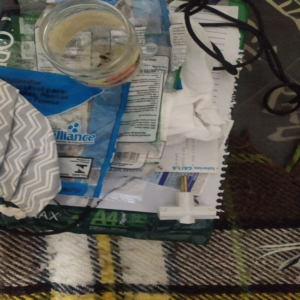




#####################################################################
Imagem: 29
Não encontrou nada
Imagem index: 29 com acerto de 0.0% acertando 0 objetos de um total de 1 objetos na imagem


Respostas corretas: 
carregador


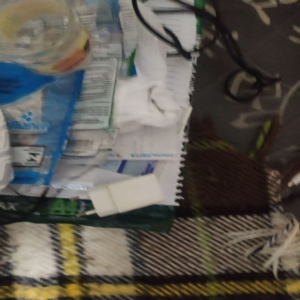




#####################################################################
Imagem: 17
Predicted carregador com certeza de: 0.9974648952484131
Predicted moeda com certeza de: 0.9970506429672241
Imagem index: 17 com acerto de 33.33333333333333% acertando 1 objetos de um total de 3 objetos na imagem


Respostas corretas: 
carregador
lapiseira
calculadora


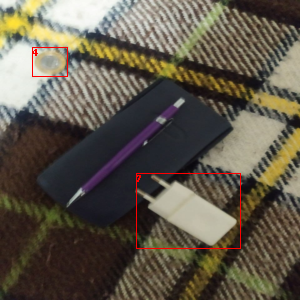




#####################################################################
Imagem: 12
Predicted controle tv com certeza de: 0.9698196053504944
Imagem index: 12 com acerto de 50.0% acertando 1 objetos de um total de 2 objetos na imagem


Respostas corretas: 
controle tv
controle ar


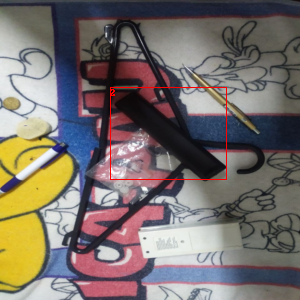




#####################################################################
Imagem: 8
Predicted lapiseira com certeza de: 0.9951404333114624
Predicted T com certeza de: 0.9827885031700134
Predicted carregador com certeza de: 0.9802067279815674
Imagem index: 8 com acerto de 75.0% acertando 3 objetos de um total de 4 objetos na imagem


Respostas corretas: 
T
carregador
lapiseira
controle tv


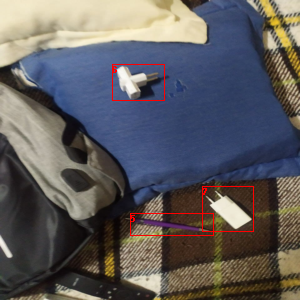




#####################################################################
Imagem: 26
Predicted controle ar com certeza de: 0.9966714382171631
Predicted controle tv com certeza de: 0.9847437739372253
Predicted carregador com certeza de: 0.963271975517273
Predicted T com certeza de: 0.9506221413612366
Predicted moeda com certeza de: 0.8016105890274048
Imagem index: 26 com acerto de 83.33333333333334% acertando 5 objetos de um total de 6 objetos na imagem


Respostas corretas: 
moeda
T
controle tv
controle ar
lapiseira
carregador


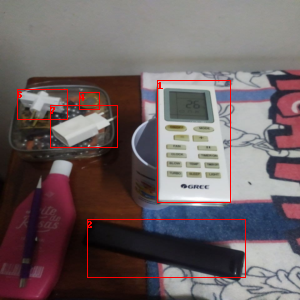




#####################################################################
Imagem: 3
Predicted controle ar com certeza de: 0.9987441301345825
Predicted T com certeza de: 0.9973852038383484
Predicted calculadora com certeza de: 0.9968562126159668
Predicted lapiseira com certeza de: 0.9957661628723145
Predicted controle tv com certeza de: 0.9911165237426758
Predicted carregador com certeza de: 0.9855881929397583
Imagem index: 3 com acerto de 85.71428571428571% acertando 6 objetos de um total de 7 objetos na imagem


Respostas corretas: 
moeda
lapiseira
calculadora
carregador
controle ar
T
controle tv


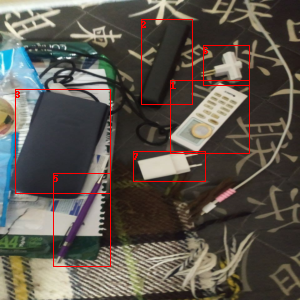




#####################################################################
Imagem: 0
Predicted controle ar com certeza de: 0.9992930889129639
Predicted lapiseira com certeza de: 0.9976083040237427
Predicted moeda com certeza de: 0.9965062141418457
Predicted controle tv com certeza de: 0.9848253130912781
Predicted T com certeza de: 0.9820848107337952
Predicted carregador com certeza de: 0.9365527033805847
Imagem index: 0 com acerto de 100.0% acertando 6 objetos de um total de 6 objetos na imagem


Respostas corretas: 
controle tv
moeda
controle ar
lapiseira
T
carregador


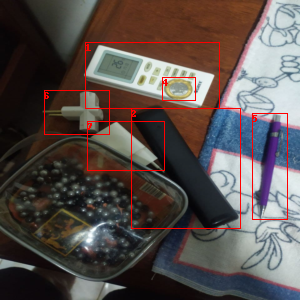




#####################################################################
Imagem: 1
Predicted moeda com certeza de: 0.9897677302360535
Imagem index: 1 com acerto de 100.0% acertando 1 objetos de um total de 1 objetos na imagem


Respostas corretas: 
moeda


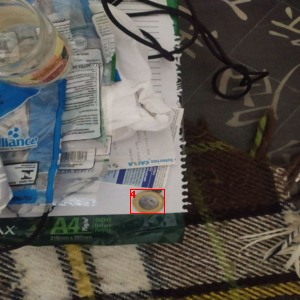




#####################################################################
Imagem: 2
Predicted controle ar com certeza de: 0.9995668530464172
Predicted calculadora com certeza de: 0.9966161847114563
Predicted carregador com certeza de: 0.9837238788604736
Predicted T com certeza de: 0.9767130017280579
Predicted moeda com certeza de: 0.9752374291419983
Predicted controle tv com certeza de: 0.9713028073310852
Predicted lapiseira com certeza de: 0.9496229290962219
Imagem index: 2 com acerto de 100.0% acertando 7 objetos de um total de 7 objetos na imagem


Respostas corretas: 
controle ar
calculadora
carregador
T
lapiseira
controle tv
moeda


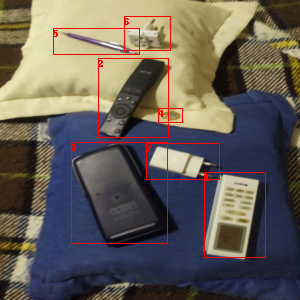




#####################################################################


In [ ]:
for test_image in list(ordered_accuracy)[:10]:
  print("Imagem: " + str(test_image))
  image_scores = set(new_preds_test_label[test_image])
  for index, predicted in enumerate(image_scores):
    print("Predicted " + str(dict_pred[new_preds_test_label[test_image][index]]) + " com certeza de: " +  str(new_preds_test_scores[test_image][index]))
  if(len(image_scores) == 0):
    print("Não encontrou nada")
  print("Imagem index: " + str(test_image) + " com acerto de " + str(images_accuracy[test_image]) + "% acertando " + str(images_total_correct_labels[test_image]) + " objetos de um total de " + str(images_expected_labels[test_image]) + " objetos na imagem")
  print("\n")

  print("Respostas corretas: ")
  for i in targets_test_new[test_image]['labels']:
    print(dict_pred[i.max().cpu().item()])

  nview = T.ToPILImage()(images_test_new[test_image]*torch.Tensor([0.229,0.224,0.225]).view(3,1,1)+torch.Tensor([0.485,0.456,0.406]).view(3,1,1))
  draw_boxes(nview,preds_test[test_image][0]['boxes'][:len(set(new_preds_test_label[test_image]))],preds_test[test_image][0]['labels'])
  print("\n\n")
  print("#####################################################################")